<a href="https://colab.research.google.com/github/mydmitrii/DS_projects/blob/main/Face_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание эмоций

In [ ]:
# импорт библиотек

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from skimage.io import imread
from skimage.io import imread_collection
import os
import random
from collections import Counter
%matplotlib inline

# модули библиотеки PyTorch
import torch
import torchvision
from torchvision import datasets, transforms, models

# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F

Загрузим датасет через kaggle api напрямую в colab

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 96% 116M/121M [00:01<00:00, 67.3MB/s]
100% 121M/121M [00:01<00:00, 65.4MB/s]


In [ ]:
!unzip face-expression-recognition-dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.j

In [ ]:
train_path = "/content/images/train"
val_path = "/content/images/validation"

Получим список классов для трейна

In [ ]:
classes = os.listdir(train_path)
classes

['happy', 'fear', 'angry', 'surprise', 'disgust', 'sad', 'neutral']

# Загрузка и подготовка dataloader-ов

In [ ]:
# конвертируем в pytorch tensor

transform_train = transforms.Compose([
        transforms.Resize((224, 224)), # увеличим размер изображений с 48х48 до 224х224, т.к. при 48х48 были плохие метрики качества
        #transforms.AutoAugment(), # отключим автоаугментацию, т.к. с ней хуже метрики
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(-20, + 20)),
        transforms.ToTensor(),
])

transform_val = transforms.Compose([
            transforms.Resize((224, 224)), # увеличим размер изображений до с 48х48 до 224х224
            transforms.ToTensor(),

])

In [ ]:
# создание датасетов
train_dataset = datasets.ImageFolder(train_path, transform=transform_train)
test_dataset = datasets.ImageFolder(val_path, transform=transform_val)

Выведем число элементов каждого класса в train_dataset и test_dataset

In [ ]:
train_class_counts = torch.bincount(torch.tensor(train_dataset.targets))
for i, count in enumerate(train_class_counts):
    class_name = classes[i]
    print(f"Количество элементов класса '{class_name}' в train_dataset: {count}")

Количество элементов класса 'happy' в train_dataset: 3993
Количество элементов класса 'fear' в train_dataset: 436
Количество элементов класса 'angry' в train_dataset: 4103
Количество элементов класса 'surprise' в train_dataset: 7164
Количество элементов класса 'disgust' в train_dataset: 4982
Количество элементов класса 'sad' в train_dataset: 4938
Количество элементов класса 'neutral' в train_dataset: 3205


In [ ]:
test_class_counts = torch.bincount(torch.tensor(test_dataset.targets))
for i, count in enumerate(test_class_counts):
    class_name = classes[i]
    print(f"Количество элементов класса '{class_name}' в test_dataset: {count}")

Количество элементов класса 'happy' в test_dataset: 960
Количество элементов класса 'fear' в test_dataset: 111
Количество элементов класса 'angry' в test_dataset: 1018
Количество элементов класса 'surprise' в test_dataset: 1825
Количество элементов класса 'disgust' в test_dataset: 1216
Количество элементов класса 'sad' в test_dataset: 1139
Количество элементов класса 'neutral' в test_dataset: 797


Визуализируем классы

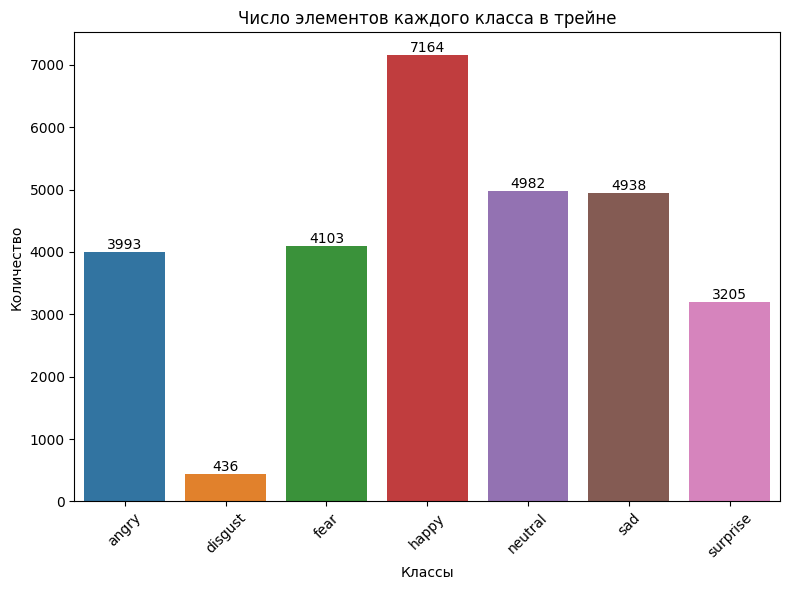

In [ ]:
# Выведем число элементов каждого класса в трейне
train_class_counts = Counter(train_dataset.targets)
class_labels_train = train_dataset.classes
class_counts_train = [train_class_counts[i] for i in range(len(train_dataset.classes))]

plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels_train, y=class_counts_train)
plt.title("Число элементов каждого класса в трейне")
plt.xlabel("Классы")
plt.ylabel("Количество")

# Добавление числового значения над каждым столбцом
for i, count in enumerate(class_counts_train):
    plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.xticks(rotation=45)  # Поворот меток оси x
plt.tight_layout()

plt.show()

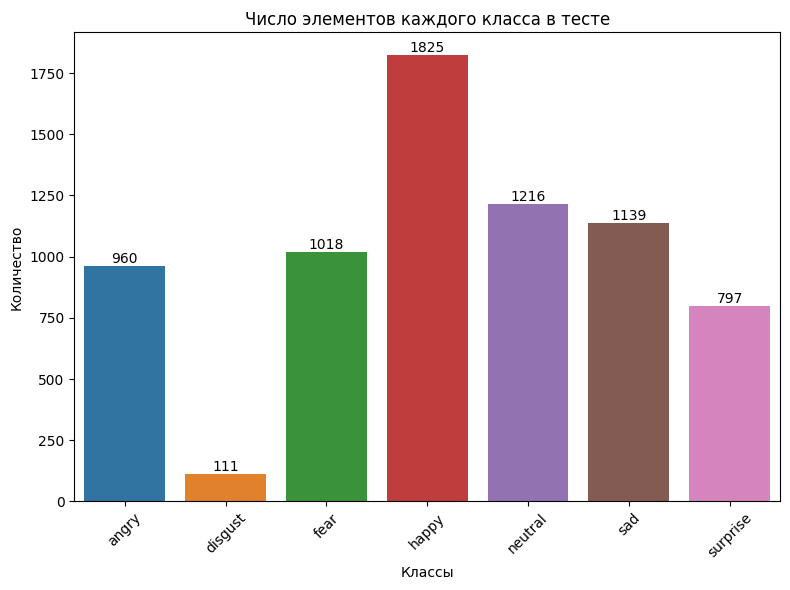

In [ ]:
# Выведем число элементов каждого класса в тесте
test_class_counts = Counter(test_dataset.targets)
class_labels_train = test_dataset.classes
class_counts_train = [test_class_counts[i] for i in range(len(test_dataset.classes))]

plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels_train, y=class_counts_train)
plt.title("Число элементов каждого класса в тесте")
plt.xlabel("Классы")
plt.ylabel("Количество")

# Добавление числового значения над каждым столбцом
for i, count in enumerate(class_counts_train):
    plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.xticks(rotation=45)  # Поворот меток оси x
plt.tight_layout()  # Улучшение отображения графика

plt.show()

In [ ]:
# загрузчики треин и тест части
train_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=32,
                                                shuffle = True,
                                                pin_memory=True,
                                                num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=32,
                                               shuffle = False,
                                               pin_memory=True,
                                               num_workers=2)

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [ ]:
# размер картинок
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Посмотрим на некоторые изображения

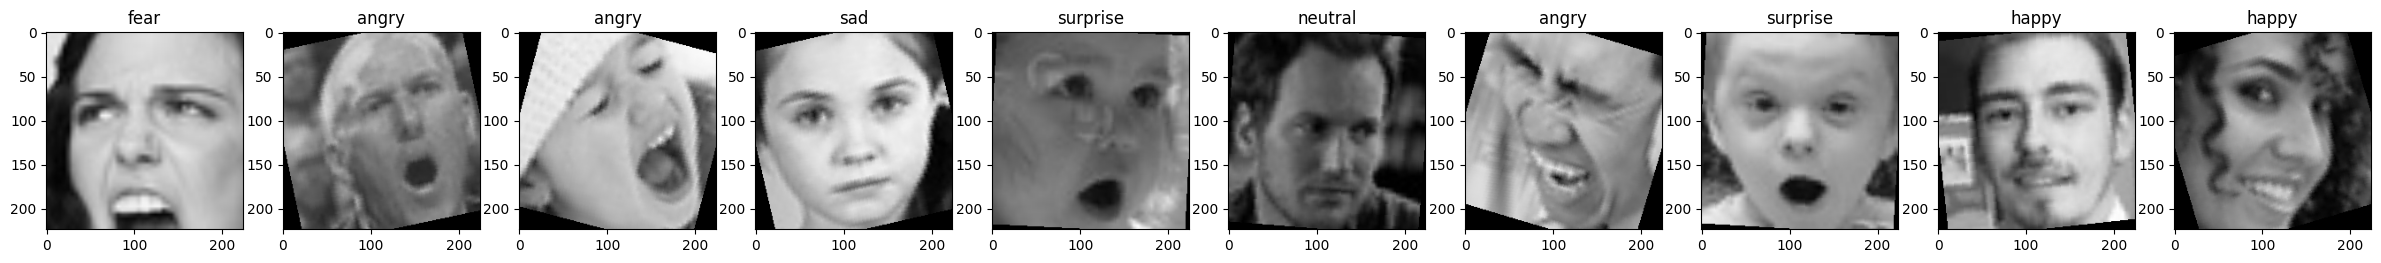

In [ ]:
# функция отображения несколько картинок
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        img = np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0)))
        label = labels[i].item()
        class_name = train_dataset.classes[label]

        axis.imshow(img, cmap='gray')
        axis.set_title(class_name)
    plt.show()

show_imgs(images, labels)

# **Файн тюнинг сети**

In [ ]:
device = torch.device('cuda')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_name()

'Tesla V100-SXM2-16GB'

In [ ]:
def train(net, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # проверяем качество каждые 500 батчей (~пол эпохи)
            if i % 500 ==0:
                # менеджер управления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        # переносим на гпу
                        x = x.to(device)
                        y = y.to(device)
                        # прогнозируем
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 200 батчей
            if i % 200 == 199:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    print('Обучение закончено')
    return net

## **Сеть VGG19**

Попробуем дообучить сеть VGG19, обученную на ImageNet, под нашу задачу.


In [ ]:
vgg19 = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 246MB/s]


In [ ]:
# нам не нужен последний слой, обрезаем его
vgg19.classifier = nn.Sequential(*list(vgg19.classifier.children()))[:-1]

In [ ]:
class New_VGG19(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg19 = vgg19 # вся огромная нейросеть в одну строчку
        for param in self.vgg19.features.parameters(): # отключаем для нее обновление параметров
            param.requires_grad = False
        self.fc = nn.Linear(4096, 7) # изменим число выходных нейронов на 7

    def forward(self, x):
        x = self.vgg19(x)
        x = x.view(x.size(0), -1)  # сгладим выход сверточных слоев
        x = self.fc(x)
        #x = F.softmax(x, dim=1)  # применим softmax для нормализации выхода
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

887

In [ ]:
net = New_VGG19().to(device)
train(net, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.25805995475113125
[1,   200] loss: 1.862
[1,   400] loss: 1.772
New best model with test acc: 0.3246171249564915
[1,   600] loss: 1.749
[1,   800] loss: 1.697


  0%|          | 0/901 [00:00<?, ?it/s]

[2,   200] loss: 1.670
[2,   400] loss: 1.648
New best model with test acc: 0.34757875043508524
[2,   600] loss: 1.646
[2,   800] loss: 1.640


  0%|          | 0/901 [00:00<?, ?it/s]

[3,   200] loss: 1.666
[3,   400] loss: 1.634
New best model with test acc: 0.34767664462234593
[3,   600] loss: 1.640
[3,   800] loss: 1.622


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.35086364427427774
[4,   200] loss: 1.590
[4,   400] loss: 1.595
New best model with test acc: 0.3654281239122868
[4,   600] loss: 1.591
[4,   800] loss: 1.600


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.36772319874695436
[5,   200] loss: 1.572
[5,   400] loss: 1.565
New best model with test acc: 0.3902388618169161
[5,   600] loss: 1.578
[5,   800] loss: 1.586


  0%|          | 0/901 [00:00<?, ?it/s]

[6,   200] loss: 1.552
[6,   400] loss: 1.569
[6,   600] loss: 1.569
[6,   800] loss: 1.589


  0%|          | 0/901 [00:00<?, ?it/s]

[7,   200] loss: 1.563
[7,   400] loss: 1.556
[7,   600] loss: 1.563
[7,   800] loss: 1.562


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.39303428471980506
[8,   200] loss: 1.570
[8,   400] loss: 1.568
[8,   600] loss: 1.564
[8,   800] loss: 1.557


  0%|          | 0/901 [00:00<?, ?it/s]

[9,   200] loss: 1.555
[9,   400] loss: 1.548
[9,   600] loss: 1.570
[9,   800] loss: 1.556


  0%|          | 0/901 [00:00<?, ?it/s]

[10,   200] loss: 1.542
[10,   400] loss: 1.538
[10,   600] loss: 1.556
[10,   800] loss: 1.535
Обучение закончено


New_VGG19(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

Метрики accuracy сети VGG19 составляют 0.393, что достаточно низкое значение

## **Сеть ResNet50**

In [ ]:
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


In [ ]:
# обрежем последний слой
resnet50.fc = nn.Sequential(*list(resnet50.fc.children()))[:-1]

In [ ]:
class New_ResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet50 = resnet50
        for param in self.resnet50.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(2048, 7)  # Change the number of output neurons to 7

    def forward(self, x):
        x = self.resnet50(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

9

In [ ]:
# обучим сеть ResNet50
net = New_ResNet50().to(device)
train(net, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.2050339366515837
[1,   200] loss: 1.721
[1,   400] loss: 1.658
New best model with test acc: 0.2455077445179255
[1,   600] loss: 1.639
[1,   800] loss: 1.589


  0%|          | 0/901 [00:00<?, ?it/s]

[2,   200] loss: 1.570
[2,   400] loss: 1.597
[2,   600] loss: 1.561
[2,   800] loss: 1.559


  0%|          | 0/901 [00:00<?, ?it/s]

[3,   200] loss: 1.553
[3,   400] loss: 1.571
[3,   600] loss: 1.560
[3,   800] loss: 1.530


  0%|          | 0/901 [00:00<?, ?it/s]

[4,   200] loss: 1.518
[4,   400] loss: 1.551
[4,   600] loss: 1.532
[4,   800] loss: 1.567


  0%|          | 0/901 [00:00<?, ?it/s]

[5,   200] loss: 1.546
[5,   400] loss: 1.523
[5,   600] loss: 1.547
[5,   800] loss: 1.548


  0%|          | 0/901 [00:00<?, ?it/s]

[6,   200] loss: 1.503
[6,   400] loss: 1.527
[6,   600] loss: 1.543
[6,   800] loss: 1.501


  0%|          | 0/901 [00:00<?, ?it/s]

[7,   200] loss: 1.515
[7,   400] loss: 1.490
[7,   600] loss: 1.518
[7,   800] loss: 1.499


  0%|          | 0/901 [00:00<?, ?it/s]

[8,   200] loss: 1.515
[8,   400] loss: 1.489
[8,   600] loss: 1.533
[8,   800] loss: 1.535


  0%|          | 0/901 [00:00<?, ?it/s]

[9,   200] loss: 1.521
[9,   400] loss: 1.500
[9,   600] loss: 1.506
[9,   800] loss: 1.475


  0%|          | 0/901 [00:00<?, ?it/s]

[10,   200] loss: 1.510
[10,   400] loss: 1.486
[10,   600] loss: 1.515
[10,   800] loss: 1.510
Обучение закончено


New_ResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

Метрики accuracy сети ResNet50 составляют 0.246, что еще ниже

## **Сеть ViT**

In [ ]:
vit_model = models.vit_b_16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:09<00:00, 36.3MB/s]


In [ ]:
vit_model.parameters #посмотрим на список параметров VIT

<bound method Module.parameters of VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, eleme

In [ ]:
class New_ViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit_model = vit_model
        for param in self.vit_model.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, 7)  # изменяем число входных нейронов на 1000

    def forward(self, x):
        x = self.vit_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

27517

In [ ]:
# обучим сеть ViT
net = New_ViT().to(device)
train(net, n_epoch=20) #обучим на большем числе эпох, т.к. на 10 эпохах были низкие метрики

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.1747737556561086
[1,   200] loss: 1.731
[1,   400] loss: 1.603
New best model with test acc: 0.41946571528019494
[1,   600] loss: 1.567
[1,   800] loss: 1.535


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.4294509223807866
[2,   200] loss: 1.474
[2,   400] loss: 1.479
New best model with test acc: 0.4656717716672468
[2,   600] loss: 1.514
[2,   800] loss: 1.436


  0%|          | 0/901 [00:00<?, ?it/s]

[3,   200] loss: 1.459
[3,   400] loss: 1.437
New best model with test acc: 0.47485207100591714
[3,   600] loss: 1.409
[3,   800] loss: 1.434


  0%|          | 0/901 [00:00<?, ?it/s]

[4,   200] loss: 1.400
[4,   400] loss: 1.409
[4,   600] loss: 1.424
[4,   800] loss: 1.405


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.4842607901148625
[5,   200] loss: 1.384
[5,   400] loss: 1.393
New best model with test acc: 0.48902497389488336
[5,   600] loss: 1.402
[5,   800] loss: 1.398


  0%|          | 0/901 [00:00<?, ?it/s]

[6,   200] loss: 1.377
[6,   400] loss: 1.401
[6,   600] loss: 1.373
[6,   800] loss: 1.390


  0%|          | 0/901 [00:00<?, ?it/s]

[7,   200] loss: 1.396
[7,   400] loss: 1.373
[7,   600] loss: 1.389
[7,   800] loss: 1.356


  0%|          | 0/901 [00:00<?, ?it/s]

[8,   200] loss: 1.351
[8,   400] loss: 1.341
New best model with test acc: 0.4938326662025757
[8,   600] loss: 1.366
[8,   800] loss: 1.364


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5066676818656457
[9,   200] loss: 1.370
[9,   400] loss: 1.353
[9,   600] loss: 1.351
[9,   800] loss: 1.356


  0%|          | 0/901 [00:00<?, ?it/s]

[10,   200] loss: 1.335
[10,   400] loss: 1.334
[10,   600] loss: 1.336
[10,   800] loss: 1.369


  0%|          | 0/901 [00:00<?, ?it/s]

[11,   200] loss: 1.326
[11,   400] loss: 1.323
[11,   600] loss: 1.338
[11,   800] loss: 1.360


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5075596066829099
[12,   200] loss: 1.325
[12,   400] loss: 1.371
[12,   600] loss: 1.342
[12,   800] loss: 1.315


  0%|          | 0/901 [00:00<?, ?it/s]

[13,   200] loss: 1.336
[13,   400] loss: 1.330
[13,   600] loss: 1.329
[13,   800] loss: 1.376


  0%|          | 0/901 [00:00<?, ?it/s]

[14,   200] loss: 1.332
[14,   400] loss: 1.329
[14,   600] loss: 1.331
[14,   800] loss: 1.343


  0%|          | 0/901 [00:00<?, ?it/s]

[15,   200] loss: 1.308
[15,   400] loss: 1.328
[15,   600] loss: 1.332
[15,   800] loss: 1.307


  0%|          | 0/901 [00:00<?, ?it/s]

[16,   200] loss: 1.318
[16,   400] loss: 1.354
[16,   600] loss: 1.341
[16,   800] loss: 1.317


  0%|          | 0/901 [00:00<?, ?it/s]

[17,   200] loss: 1.321
[17,   400] loss: 1.311
New best model with test acc: 0.5076901322659241
[17,   600] loss: 1.307
[17,   800] loss: 1.330


  0%|          | 0/901 [00:00<?, ?it/s]

[18,   200] loss: 1.329
[18,   400] loss: 1.293
[18,   600] loss: 1.342
[18,   800] loss: 1.291


  0%|          | 0/901 [00:00<?, ?it/s]

[19,   200] loss: 1.324
[19,   400] loss: 1.324
New best model with test acc: 0.5091041594152453
[19,   600] loss: 1.342
[19,   800] loss: 1.322


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5095283675600417
[20,   200] loss: 1.304
[20,   400] loss: 1.337
[20,   600] loss: 1.294
[20,   800] loss: 1.316
Обучение закончено


New_ViT(
  (vit_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Lay

Сеть ViT дает лучшие метрики качества. Но все равно accuracy 0.51 - очень низкое значение. Проверим его на тестовом датасете

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [ ]:
# размер датасета
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

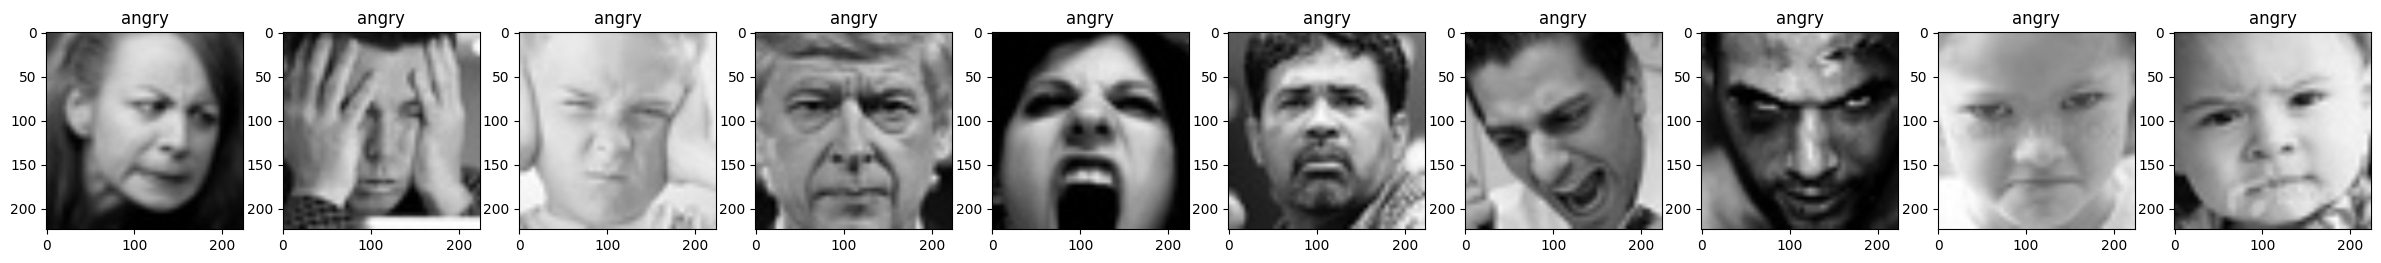

In [ ]:
# посмотрим на некоторые изображения
show_imgs(images, labels)

In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(net.forward(images.cuda()).detach().cpu().numpy())

In [ ]:
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.5108972544579677

Метрики тестового датасета соответствуют метрикам трейна

# Оценка модели

Classification Report:
              precision    recall  f1-score   support

        fear       0.41      0.32      0.36       960
       happy       0.54      0.23      0.32       111
     neutral       0.55      0.17      0.25      1018
     disgust       0.61      0.79      0.69      1825
         sad       0.46      0.49      0.48      1216
       angry       0.38      0.49      0.43      1139
    surprise       0.60      0.65      0.62       797

    accuracy                           0.51      7066
   macro avg       0.51      0.45      0.45      7066
weighted avg       0.51      0.51      0.49      7066



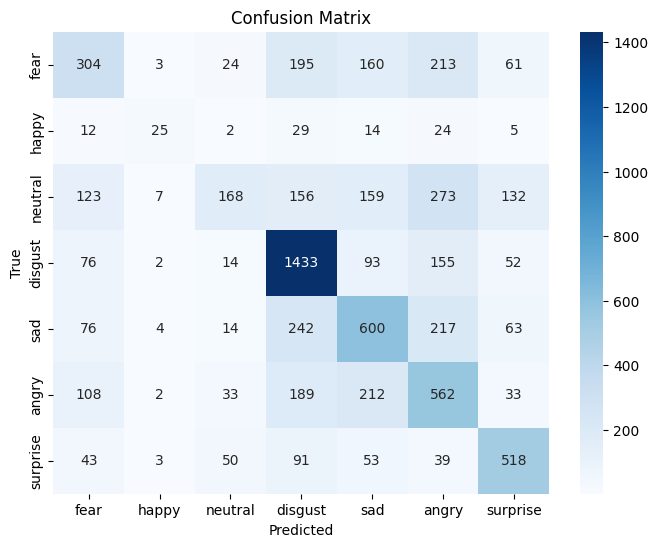

In [ ]:
# Преобразование предсказанных меток в индексы класса
labels_pred = [np.argmax(label) for label in labels_net]

# Classification report
classification_rep = classification_report(labels_true, labels_pred, target_names=classes)
print("Classification Report:")
print(classification_rep)

# Confusion matrix
cm = confusion_matrix(labels_true, labels_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Лучше всего предсказания работают в классе disqust, хуже всего в happy

Отобразим изображения с тестового датасета с предсказаниями и рельной меткой класса

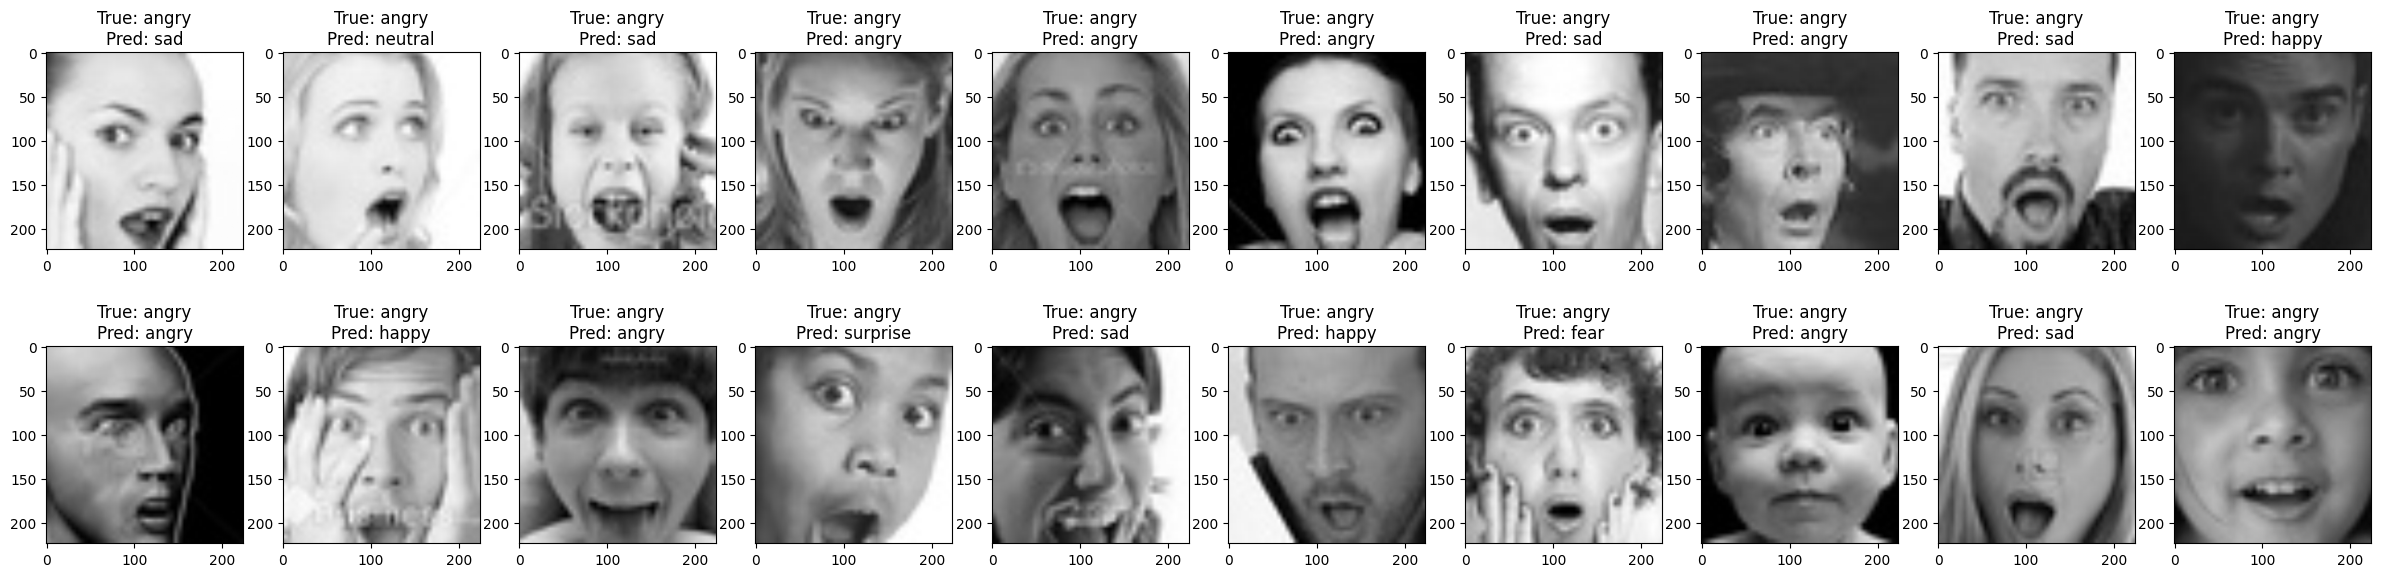

In [ ]:
def show_imgs_with_labels(imgs, labels_true, labels_pred):
    f, axes = plt.subplots(2, 10, figsize=(30, 7))
    for i, axis in enumerate(axes.flat):
        img = np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0)))
        true_label = labels_true[i].item()
        pred_label = labels_pred[i]

        true_class_name = train_dataset.classes[true_label]
        pred_class_name = train_dataset.classes[pred_label]

        axis.imshow(img, cmap='gray')
        axis.set_title(f'True: {true_class_name}\nPred: {pred_class_name}')
    plt.show()

show_imgs_with_labels(images, labels_true, labels_pred)


# Квантизация модели

In [ ]:
# загрузим предобученную ViT модель
net = New_ViT()
net.load_state_dict(torch.load('./best_model.pt'))
net.eval()

New_ViT(
  (vit_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Lay

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [ ]:
# Динамическая квантизация модели
quantized_net = torch.quantization.quantize_dynamic(
    net, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
)

In [ ]:
# отобразим квантизированную модель
print('Here is the quantized version of the ViT model:')
print(quantized_net)

Here is the quantized version of the ViT model:
New_ViT(
  (vit_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): DynamicQuantizedLinear(in_features=768, out_features=3072, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): DynamicQuantizedLinear(in_features=3072, out_features=768, dtype=torch.qint8, qs

In [ ]:
# функция для отображения размера модели
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [ ]:
# сравним размеры моделей
f = print_size_of_model(net, "Float32")
q = print_size_of_model(quantized_net, "Int8")
print("{0:.2f} times smaller".format(f / q))

model:  Float32  	 Size (KB): 346352.057
model:  Int8  	 Size (KB): 174178.357
1.99 times smaller


Квантизированная модель практически в 2 раза меньше!

In [ ]:
# ввод для проверки моделей
input_shape = (1, 3, 224, 224)
dummy_input = torch.randn(*input_shape).to(device)

In [ ]:
# Скорость модели
print("Floating point (Float32)")
%timeit net(dummy_input)

Floating point (Float32)
7.08 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


При подсчете скорости для квантизированной модели:

*%timeit quantized_net(dummy_input)* выдавал ошибку "apply_relu_out" , даже в случае переноса модели на CPU

In [ ]:
# перенесем квантизированную модель на CPU
quantized_net = quantized_net.to('cpu')
dummy_input = dummy_input.to('cpu')

In [ ]:
# ДАННЫЙ КОД ВЫДАЕТ ОШИБКУ, ПОЭТОМУ СКОРОСТЬ НЕ ПОСЧИТАЛ
print("Quantized (Int8)")
%timeit quantized_net(dummy_input)

# Дистилляция модели в mobilenetv3

Дистиллируем лучшую модельViT в компактную архитектуру mobilenetv3

In [ ]:
net = New_ViT().to(device)

## Функции обучения студента

In [ ]:
def loss_fn_kd(outputs, labels, teacher_outputs, alpha, T):
    """
    Дистиляционные потери (KD loss)
    Inp:
        outputs - выходы ученика
        labels - разметка
        teacher_outputs - выходы учителя
        alpha - гиперпараметр
        T - температура софтмакса (гиперпараметр)

    ПРИМЕЧАНИЕ: дивергенция Кульбака-Лейблера для PyTorch, сравнивающая softmax учителя
    и ученика ожидает, что входной тензор будет логарифмической вероятностью
    """
    # print(F.log_softmax(outputs/T, dim=1).size(), F.softmax(teacher_outputs/T, dim=1).size())
    # print(outputs.size(), labels.size())
    # KD_loss = nn.KLDivLoss((F.log_softmax(outputs/T, dim=1), F.softmax(teacher_outputs/T, dim=1)), reduction='batchmean') * (alpha * T * T) + F.cross_entropy(outputs, labels) * (1. - alpha)
    KD_loss = F.cross_entropy(outputs, labels) * (1. - alpha) + F.kl_div(F.log_softmax(outputs/T, dim=1), F.softmax(teacher_outputs/T, dim=1), reduction='batchmean') * (T * T)
    # print(KD_loss.item())
    return KD_loss

In [ ]:
class RunningAverage():
    """
    Скользящее среднее по метрикам
    Пример:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total/float(self.steps)

In [ ]:
from torch.autograd import Variable
def train_kd(model, teacher_model, optimizer, train_loader, test_loader, num_ep, alpha, T):
    # set model to training mode
    model = model.train()
    teacher_model = teacher_model.to(device).eval()

    # teacher_model = teacher_model.eval()
    best_accuracy = 0.
    loss_avg = RunningAverage()
    for ep in range(num_ep):
        print('Epoch', ep)
        # Use tqdm for progress bar
        with tqdm(total=len(train_loader)) as t:
            for i, (train_batch, labels_batch) in enumerate(train_loader):
                train_batch, labels_batch = train_batch.to(device), labels_batch.to(device)

                # compute model output, fetch teacher output, and compute KD loss
                output_batch = model(train_batch)

                # get one batch output from teacher_outputs list

                with torch.no_grad():
                    output_teacher_batch = teacher_model(train_batch)
                # print(output_teacher_batch)
                # output_teacher_batch = Variable(output_teacher_batch, requires_grad=False)

                # loss = loss_fn_kd(output_batch, labels_batch, output_teacher_batch, alpha, T)
                # print(output_batch.size())
                # print(labels.size())
                output_teacher_batch.requires_grad=False

                loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output_batch/T, dim=1),
                                        F.softmax(output_teacher_batch/T, dim=1)) * (alpha * T * T) + \
                        F.cross_entropy(output_batch, labels_batch) * (1. - alpha)

                optimizer.zero_grad()
                loss.backward()

                # performs updates using calculated gradients
                optimizer.step()

                # update the average loss
                loss_avg.update(loss.item())

                t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
                t.update()

                # if i %30:
                #     print('avg train loss', loss_avg())
                #     loss_avg = RunningAverage()

        # в конце эпохи валидируем
        accuracy = []
        for batch in test_loader:
            x, y = batch
            # переносим на гпу
            x, y = x.to(device), y.to(device)
            # прогнозируем
            y_pred = model(x)
            # loss = loss_fn(y_pred, y)
            # находим accuracy батча с теста
            accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
        # усредняем accuracy всех батчей на тесте
        accuracy = np.mean(np.array(accuracy))
        # если стало лучше - сохраняем на диск и обновляем лучшую метрику
        if accuracy > best_accuracy:
            print('New best model with test acc:', accuracy)
            torch.save(model.state_dict(), './best_model_student.pt')
            best_accuracy = accuracy

## Модель студента

In [ ]:
mobilenetv3 = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 28.0MB/s]


In [ ]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        # удалим последний слой MobileNetV3
        self.features = nn.Sequential(*list(mobilenetv3.children())[:-1])
        self.fc = nn.Linear(576, 7)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Процесс дистилляции

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

# Create the student model
student_model = StudentModel().to(device)

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)
train_kd(student_model, net, optimizer, train_loader, test_loader, 10, 0.8, 1.2)

Epoch 0


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.2525778802645319
Epoch 1


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.26367255482074486
Epoch 2


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.27859597981204315
Epoch 3


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.28714540549947787
Epoch 4


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.3009049773755656
Epoch 5


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.3106182561782109
Epoch 6


  0%|          | 0/901 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.3192438217890706
Epoch 8


  0%|          | 0/901 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/901 [00:00<?, ?it/s]

Метрики модели студента получились низкие